In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
import warnings
import pickle

# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Libraries imported successfully!")

Using device: cuda
Libraries imported successfully!


In [3]:
# Define paths
OUTPUT_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\processed_data"
RESULTS_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\results"

# Create results directory
os.makedirs(RESULTS_PATH, exist_ok=True)

# Load preprocessed data
print("Loading preprocessed data...")
features = np.load(os.path.join(OUTPUT_PATH, 'features_normalized.npy'))
labels = np.load(os.path.join(OUTPUT_PATH, 'labels.npy'), allow_pickle=True)
metadata = pd.read_csv(os.path.join(OUTPUT_PATH, 'metadata.csv'))

print(f"\nData loaded successfully!")
print(f"Features shape: {features.shape}")
print(f"Number of samples: {len(labels)}")
print(f"Number of unique labels: {len(np.unique(labels))}")

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(f"Label classes: {label_encoder.classes_}")

Loading preprocessed data...

Data loaded successfully!
Features shape: (1859, 370)
Number of samples: 1859
Number of unique labels: 8
Label classes: ['disco' 'hiphop' 'indie' 'jazz' 'metal' 'pop' 'rock' 'traditional']


In [4]:
class VAE(nn.Module):
    """Variational Autoencoder for music feature extraction."""
    
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], latent_dim=64):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: input_dim -> 512 -> 256 -> 128 -> latent_dim
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder: latent_dim -> 128 -> 256 -> 512 -> input_dim
        decoder_layers = []
        hidden_dims_rev = hidden_dims[::-1]  # [128, 256, 512]
        prev_dim = latent_dim
        for hidden_dim in hidden_dims_rev:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        decoder_layers.append(nn.Linear(hidden_dims_rev[-1], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z
    
    def get_latent_features(self, x):
        mu, _ = self.encode(x)
        return mu

print("VAE architecture defined!")

VAE architecture defined!


In [17]:
def vae_loss(reconstruction, x, mu, logvar, beta=0.8):

    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(reconstruction, x, reduction='mean')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

print("VAE loss function defined!")

# VAE Configuration
VAE_CONFIG = {
    'hidden_dims': [128, 64, 32],   # Hidden layer dimensions
    'latent_dim': 32,                 # Latent space dimension
    'learning_rate': 1e-4,
    'batch_size': 32,
    'epochs': 500,
    'beta': 0.8,                      # KL divergence weight
    'patience': 15,                   # Early stopping patience
}

print("VAE Configuration:")
for key, value in VAE_CONFIG.items():
    print(f"  {key}: {value}")
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(features)

# Create DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(
    dataset, 
    batch_size=VAE_CONFIG['batch_size'], 
    shuffle=True
)

print(f"\nDataLoader created with {len(dataloader)} batches")

VAE loss function defined!
VAE Configuration:
  hidden_dims: [128, 64, 32]
  latent_dim: 32
  learning_rate: 0.0001
  batch_size: 32
  epochs: 500
  beta: 0.8
  patience: 15

DataLoader created with 59 batches


In [18]:
# Initialize VAE
input_dim = features.shape[1]
vae = VAE(
    input_dim=input_dim,
    hidden_dims=VAE_CONFIG['hidden_dims'],
    latent_dim=VAE_CONFIG['latent_dim']
).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=VAE_CONFIG['learning_rate'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15
)

print(f"\nVAE Model Summary:")
print(f"  Input dimension: {input_dim}")
print(f"  Hidden dimensions: {VAE_CONFIG['hidden_dims']}")
print(f"  Latent dimension: {VAE_CONFIG['latent_dim']}")
print(f"  Total parameters: {sum(p.numel() for p in vae.parameters())}")

# Training loop
print("\n" + "="*60)
print("TRAINING VAE")
print("="*60)

train_losses = []
recon_losses = []
kl_losses = []
best_loss = float('inf')
patience_counter = 0

for epoch in range(VAE_CONFIG['epochs']):
    vae.train()
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0
    
    for batch in dataloader:
        x = batch[0].to(device)
        
        # Forward pass
        reconstruction, mu, logvar, z = vae(x)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(
            reconstruction, x, mu, logvar, VAE_CONFIG['beta']
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    
    # Average losses
    avg_loss = epoch_loss / len(dataloader)
    avg_recon = epoch_recon / len(dataloader)
    avg_kl = epoch_kl / len(dataloader)
    
    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        torch.save(vae.state_dict(), os.path.join(RESULTS_PATH, 'best_vae_model.pth'))
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{VAE_CONFIG['epochs']}] - "
              f"Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")
    
    if patience_counter >= VAE_CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\nTraining complete!")


VAE Model Summary:
  Input dimension: 370
  Hidden dimensions: [128, 64, 32]
  Latent dimension: 32
  Total parameters: 120050

TRAINING VAE
Epoch [10/500] - Loss: 0.9389, Recon: 0.8721, KL: 0.0834
Epoch [20/500] - Loss: 0.7909, Recon: 0.7123, KL: 0.0983
Epoch [30/500] - Loss: 0.7623, Recon: 0.6870, KL: 0.0941
Epoch [40/500] - Loss: 0.7635, Recon: 0.6905, KL: 0.0912
Epoch [50/500] - Loss: 0.7539, Recon: 0.6858, KL: 0.0852
Epoch [60/500] - Loss: 0.7280, Recon: 0.6605, KL: 0.0844
Epoch [70/500] - Loss: 0.7277, Recon: 0.6621, KL: 0.0820
Epoch [80/500] - Loss: 0.7095, Recon: 0.6469, KL: 0.0783
Epoch [90/500] - Loss: 0.7178, Recon: 0.6571, KL: 0.0759
Epoch [100/500] - Loss: 0.7005, Recon: 0.6418, KL: 0.0733
Epoch [110/500] - Loss: 0.6953, Recon: 0.6391, KL: 0.0703
Epoch [120/500] - Loss: 0.6962, Recon: 0.6429, KL: 0.0666
Epoch [130/500] - Loss: 0.6855, Recon: 0.6334, KL: 0.0652
Epoch [140/500] - Loss: 0.6938, Recon: 0.6442, KL: 0.0620
Epoch [150/500] - Loss: 0.6764, Recon: 0.6276, KL: 0.06

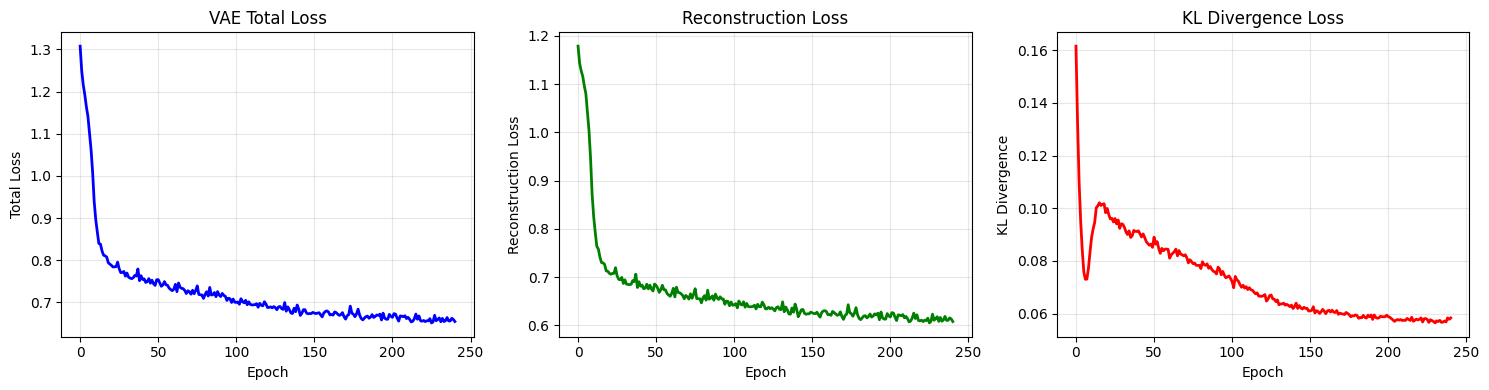

Training curves saved to f:\BRACU\Semester 12 Final\CSE425\FInal_project\results/training_curves.png


In [19]:
ig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(train_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('VAE Total Loss')
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(recon_losses, 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].grid(True, alpha=0.3)

# KL divergence
axes[2].plot(kl_losses, 'r-', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'training_curves.png'), dpi=150)
plt.show()

print(f"Training curves saved to {RESULTS_PATH}/training_curves.png")

In [20]:
print("\n" + "="*60)
print("EXTRACTING LATENT FEATURES")
print("="*60)

# Load best model
vae.load_state_dict(torch.load(os.path.join(RESULTS_PATH, 'best_vae_model.pth')))
vae.eval()

# Extract latent features
with torch.no_grad():
    X_tensor_device = X_tensor.to(device)
    latent_features = vae.get_latent_features(X_tensor_device).cpu().numpy()

print(f"Latent features shape: {latent_features.shape}")

# Save latent features
np.save(os.path.join(RESULTS_PATH, 'latent_features.npy'), latent_features)
print(f"Latent features saved to {RESULTS_PATH}/latent_features.npy")


EXTRACTING LATENT FEATURES
Latent features shape: (1859, 32)
Latent features saved to f:\BRACU\Semester 12 Final\CSE425\FInal_project\results/latent_features.npy



DETERMINING OPTIMAL NUMBER OF CLUSTERS
K=2: Silhouette=0.5314, Calinski-Harabasz=3027.67
K=3: Silhouette=0.5479, Calinski-Harabasz=4146.42
K=4: Silhouette=0.5306, Calinski-Harabasz=4910.81
K=5: Silhouette=0.5151, Calinski-Harabasz=5509.50
K=6: Silhouette=0.5296, Calinski-Harabasz=6411.21
K=7: Silhouette=0.5233, Calinski-Harabasz=6854.94
K=8: Silhouette=0.5242, Calinski-Harabasz=7778.72
K=9: Silhouette=0.5324, Calinski-Harabasz=8818.65
K=10: Silhouette=0.5300, Calinski-Harabasz=9681.72
K=11: Silhouette=0.5170, Calinski-Harabasz=10035.17
K=12: Silhouette=0.5103, Calinski-Harabasz=10718.61
K=13: Silhouette=0.5095, Calinski-Harabasz=11074.30
K=14: Silhouette=0.5108, Calinski-Harabasz=11804.18


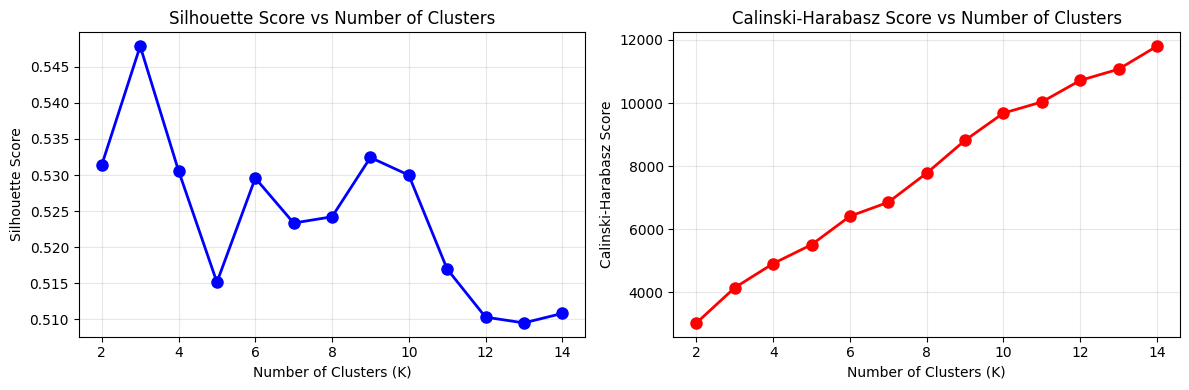


Optimal number of clusters: 3


In [21]:
# CELL 10: Determine Optimal Number of Clusters

print("\n" + "="*60)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

# Test different numbers of clusters
k_range = range(2, 15)
silhouette_scores = []
ch_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(latent_features)
    
    sil_score = silhouette_score(latent_features, cluster_labels)
    ch_score = calinski_harabasz_score(latent_features, cluster_labels)
    
    silhouette_scores.append(sil_score)
    ch_scores.append(ch_score)
    
    print(f"K={k}: Silhouette={sil_score:.4f}, Calinski-Harabasz={ch_score:.2f}")

# Plot elbow curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs Number of Clusters')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, ch_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_title('Calinski-Harabasz Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'cluster_optimization.png'), dpi=150)
plt.show()

# Select optimal K (based on silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

In [22]:
print("\n" + "="*60)
print("K-MEANS CLUSTERING ON VAE LATENT FEATURES")
print("="*60)

# Perform K-Means clustering
kmeans_vae = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
vae_clusters = kmeans_vae.fit_predict(latent_features)

# Calculate clustering metrics
vae_silhouette = silhouette_score(latent_features, vae_clusters)
vae_ch_score = calinski_harabasz_score(latent_features, vae_clusters)

print(f"\nVAE + K-Means Results:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette Score: {vae_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {vae_ch_score:.2f}")

# Save cluster assignments
np.save(os.path.join(RESULTS_PATH, 'vae_clusters.npy'), vae_clusters)


K-MEANS CLUSTERING ON VAE LATENT FEATURES

VAE + K-Means Results:
  Number of clusters: 3
  Silhouette Score: 0.5479
  Calinski-Harabasz Index: 4146.42


In [23]:
print("\n" + "="*60)
print("BASELINE: PCA + K-MEANS CLUSTERING")
print("="*60)

# Apply PCA with same number of components as VAE latent dim
pca = PCA(n_components=VAE_CONFIG['latent_dim'])
pca_features = pca.fit_transform(features)

print(f"PCA features shape: {pca_features.shape}")
print(f"Explained variance ratio (total): {pca.explained_variance_ratio_.sum():.4f}")

# K-Means on PCA features
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)

# Calculate baseline metrics
pca_silhouette = silhouette_score(pca_features, pca_clusters)
pca_ch_score = calinski_harabasz_score(pca_features, pca_clusters)

print(f"\nPCA + K-Means Results:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette Score: {pca_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {pca_ch_score:.2f}")

# Save PCA results
np.save(os.path.join(RESULTS_PATH, 'pca_features.npy'), pca_features)
np.save(os.path.join(RESULTS_PATH, 'pca_clusters.npy'), pca_clusters)


BASELINE: PCA + K-MEANS CLUSTERING
PCA features shape: (1859, 32)
Explained variance ratio (total): 0.8863

PCA + K-Means Results:
  Number of clusters: 3
  Silhouette Score: 0.1761
  Calinski-Harabasz Index: 671.96



COMPARISON: VAE vs PCA BASELINE


                  Method  Silhouette Score  Calinski-Harabasz Index
           VAE + K-Means          0.547868              4146.418040
PCA + K-Means (Baseline)          0.176137               671.963076

Improvement of VAE over PCA baseline:
  Silhouette Score: +211.05%
  Calinski-Harabasz Index: +517.06%


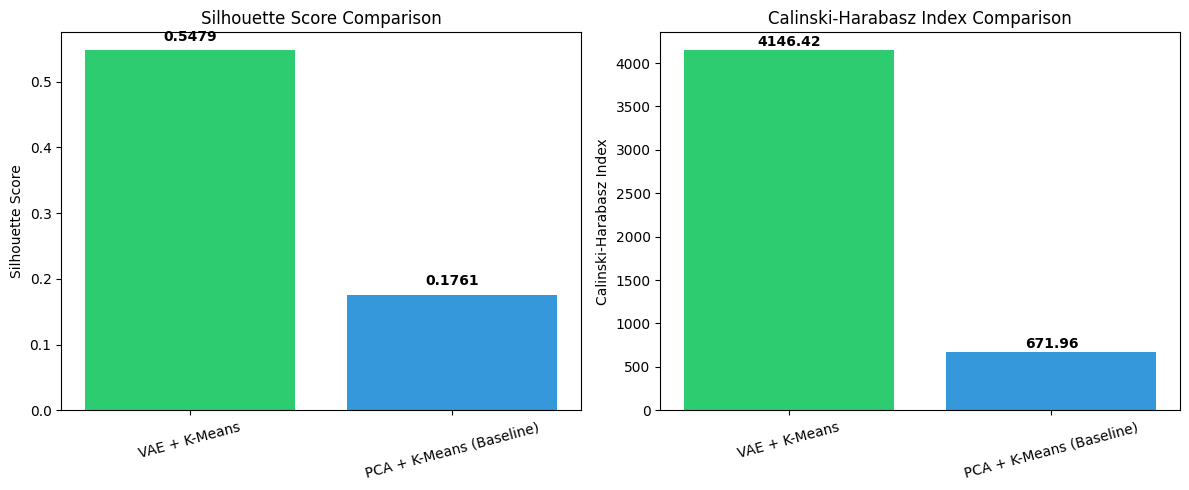

In [24]:
print("\n" + "="*60)
print("COMPARISON: VAE vs PCA BASELINE")
print("="*60)

comparison_data = {
    'Method': ['VAE + K-Means', 'PCA + K-Means (Baseline)'],
    'Silhouette Score': [vae_silhouette, pca_silhouette],
    'Calinski-Harabasz Index': [vae_ch_score, pca_ch_score]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

# Calculate improvement
silhouette_improvement = ((vae_silhouette - pca_silhouette) / abs(pca_silhouette)) * 100
ch_improvement = ((vae_ch_score - pca_ch_score) / pca_ch_score) * 100

print(f"\nImprovement of VAE over PCA baseline:")
print(f"  Silhouette Score: {silhouette_improvement:+.2f}%")
print(f"  Calinski-Harabasz Index: {ch_improvement:+.2f}%")

# Save comparison
comparison_df.to_csv(os.path.join(RESULTS_PATH, 'method_comparison.csv'), index=False)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Silhouette Score comparison
colors = ['#2ecc71', '#3498db']
axes[0].bar(comparison_data['Method'], comparison_data['Silhouette Score'], color=colors)
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score Comparison')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_data['Silhouette Score']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Calinski-Harabasz comparison
axes[1].bar(comparison_data['Method'], comparison_data['Calinski-Harabasz Index'], color=colors)
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index Comparison')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_data['Calinski-Harabasz Index']):
    axes[1].text(i, v + 10, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'method_comparison.png'), dpi=150)
plt.show()

Applying t-SNE to VAE latent features...
(1859, 2)


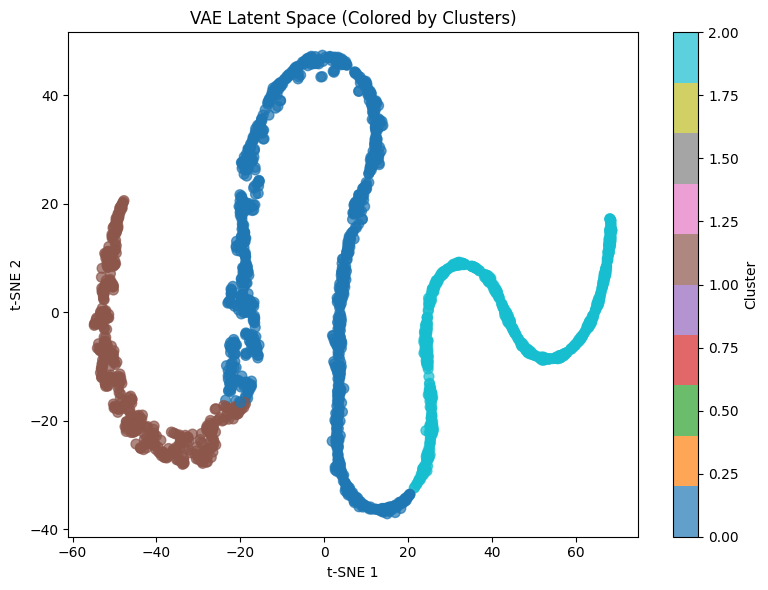

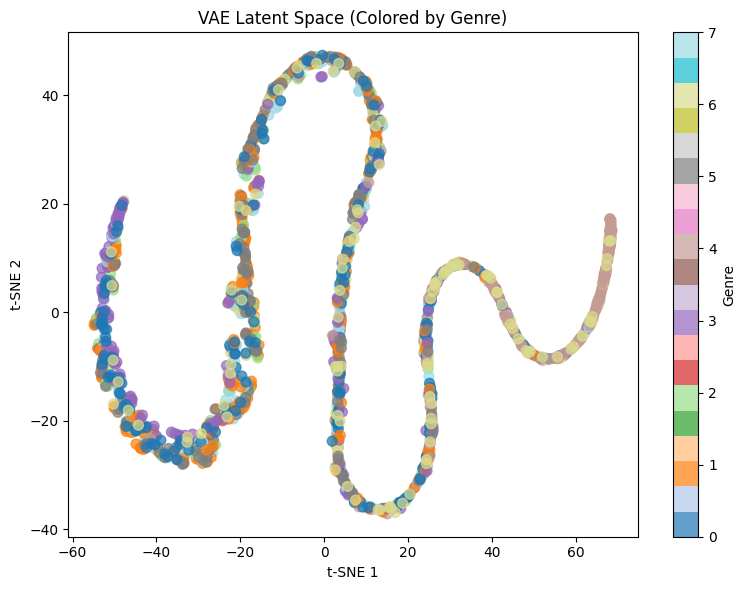

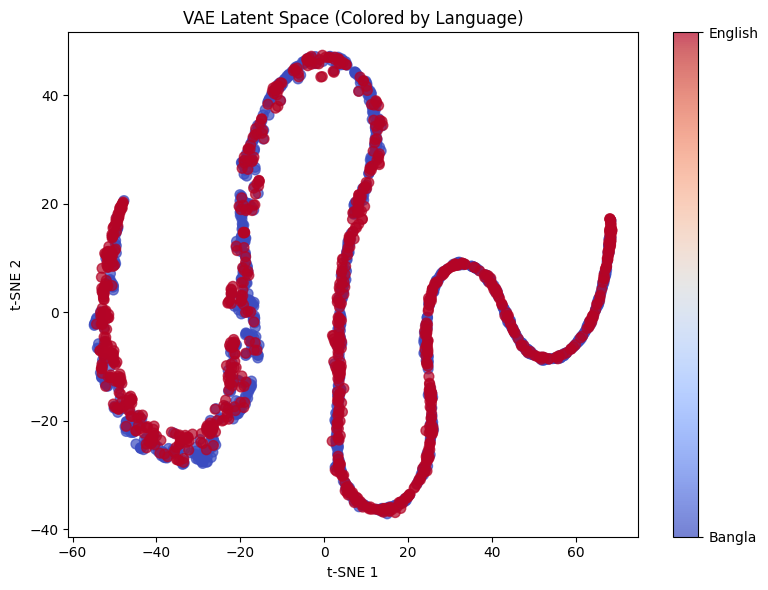

t-SNE visualizations saved to f:\BRACU\Semester 12 Final\CSE425\FInal_project\results


In [25]:
# Apply t-SNE to VAE latent features
print("Applying t-SNE to VAE latent features...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_tsne = tsne.fit_transform(latent_features)
print(latent_tsne.shape)
# Plot 1: Colored by VAE clusters
plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                       c=vae_clusters, cmap='tab10', alpha=0.7, s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('VAE Latent Space (Colored by Clusters)')
plt.colorbar(scatter1, label='Cluster')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_clusters.png'), dpi=150)
plt.show()

# Plot 2: Colored by genre
plt.figure(figsize=(8, 6))
scatter2 = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                       c=labels_encoded, cmap='tab20', alpha=0.7, s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('VAE Latent Space (Colored by Genre)')
plt.colorbar(scatter2, label='Genre')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_genre.png'), dpi=150)
plt.show()

# Plot 3: Colored by language
plt.figure(figsize=(8, 6))
languages = metadata['language'].map({'bn': 0, 'en': 1}).values
scatter3 = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                       c=languages, cmap='coolwarm', alpha=0.7, s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('VAE Latent Space (Colored by Language)')
cbar3 = plt.colorbar(scatter3)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Bangla', 'English'])
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_language.png'), dpi=150)
plt.show()

print(f"t-SNE visualizations saved to {RESULTS_PATH}")


COMPARISON VISUALIZATION: VAE vs PCA
Applying t-SNE to PCA features...


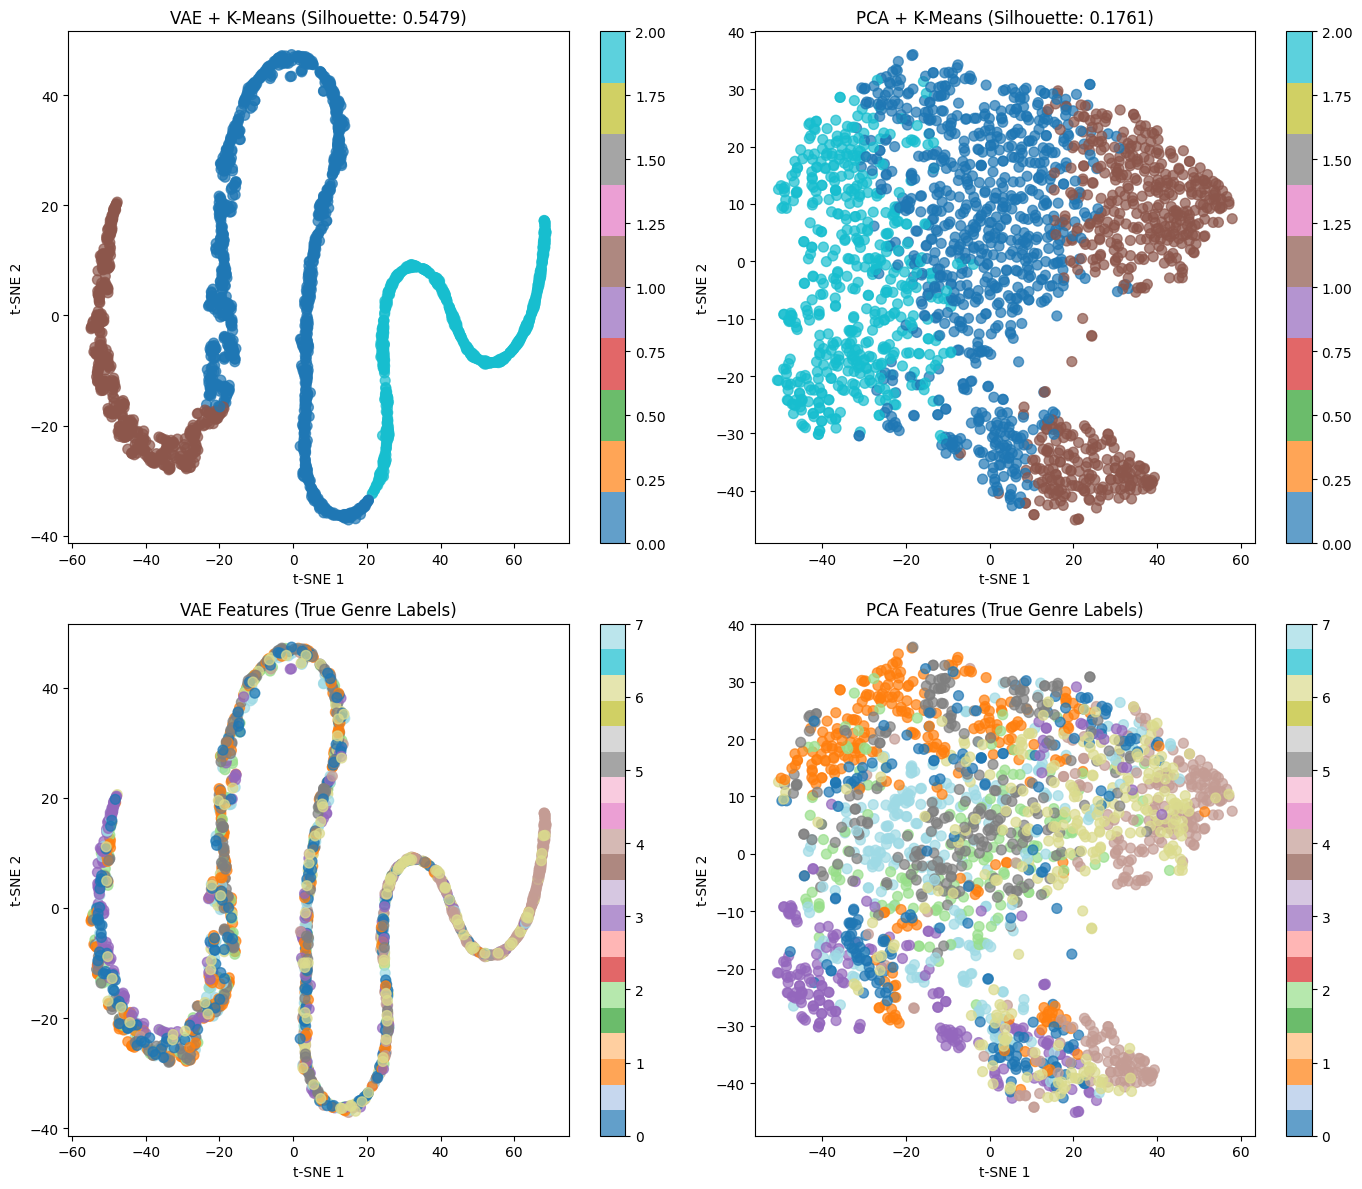

In [26]:
print("\n" + "="*60)
print("COMPARISON VISUALIZATION: VAE vs PCA")
print("="*60)

# t-SNE on PCA features for comparison
print("Applying t-SNE to PCA features...")
pca_tsne = tsne.fit_transform(pca_features)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# VAE t-SNE colored by clusters
scatter1 = axes[0, 0].scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                              c=vae_clusters, cmap='tab10', alpha=0.7, s=50)
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')
axes[0, 0].set_title(f'VAE + K-Means (Silhouette: {vae_silhouette:.4f})')
plt.colorbar(scatter1, ax=axes[0, 0])

# PCA t-SNE colored by clusters
scatter2 = axes[0, 1].scatter(pca_tsne[:, 0], pca_tsne[:, 1], 
                              c=pca_clusters, cmap='tab10', alpha=0.7, s=50)
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
axes[0, 1].set_title(f'PCA + K-Means (Silhouette: {pca_silhouette:.4f})')
plt.colorbar(scatter2, ax=axes[0, 1])

# VAE t-SNE colored by true genre
scatter3 = axes[1, 0].scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                              c=labels_encoded, cmap='tab20', alpha=0.7, s=50)
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
axes[1, 0].set_title('VAE Features (True Genre Labels)')
plt.colorbar(scatter3, ax=axes[1, 0])

# PCA t-SNE colored by true genre
scatter4 = axes[1, 1].scatter(pca_tsne[:, 0], pca_tsne[:, 1], 
                              c=labels_encoded, cmap='tab20', alpha=0.7, s=50)
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')
axes[1, 1].set_title('PCA Features (True Genre Labels)')
plt.colorbar(scatter4, ax=axes[1, 1])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'vae_vs_pca_comparison.png'), dpi=150)
plt.show()


CLUSTER ANALYSIS

VAE Cluster Composition (by Genre):
genre        disco  hiphop  indie  jazz  metal  pop  rock  traditional
vae_cluster                                                           
0              101     172    105    55     25  192   116          153
1               62      70     42   111      3   56    15           83
2               37      18     13    33    232   12   129           24

VAE Cluster Composition (by Language):
language      bn   en
vae_cluster          
0            531  388
1            184  258
2            245  253


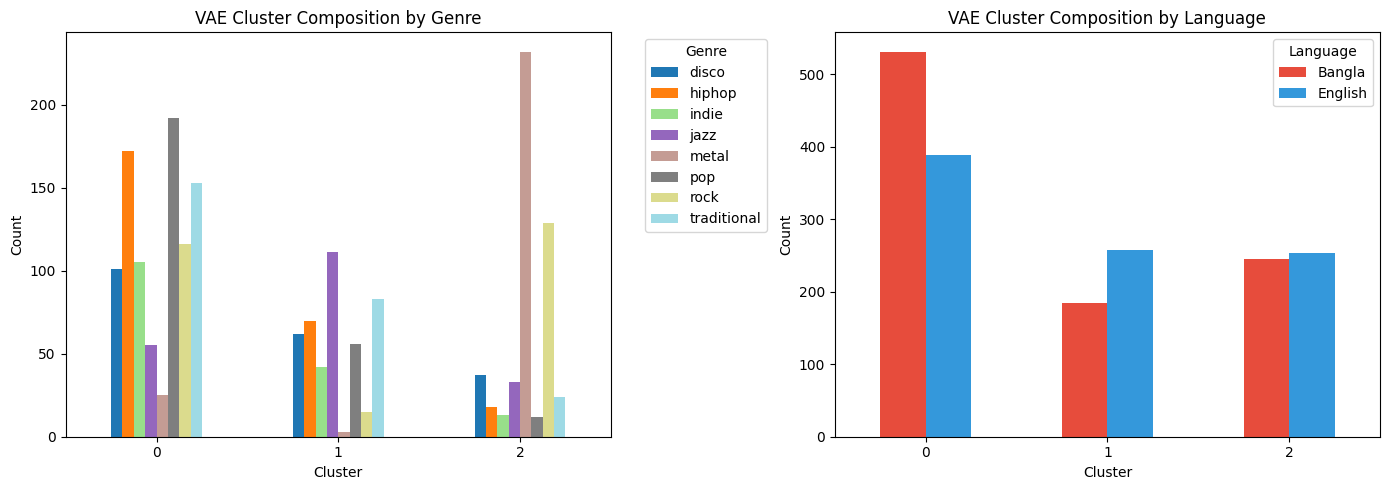

In [27]:

print("\n" + "="*60)
print("CLUSTER ANALYSIS")
print("="*60)

# Analyze cluster composition
cluster_analysis = metadata.copy()
cluster_analysis['vae_cluster'] = vae_clusters
cluster_analysis['pca_cluster'] = pca_clusters

print("\nVAE Cluster Composition (by Genre):")
print(pd.crosstab(cluster_analysis['vae_cluster'], cluster_analysis['genre']))

print("\nVAE Cluster Composition (by Language):")
print(pd.crosstab(cluster_analysis['vae_cluster'], cluster_analysis['language']))

# Create cluster composition visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster composition by genre
genre_cluster_df = pd.crosstab(cluster_analysis['vae_cluster'], cluster_analysis['genre'])
genre_cluster_df.plot(kind='bar', ax=axes[0], colormap='tab20')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')
axes[0].set_title('VAE Cluster Composition by Genre')
axes[0].legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=0)

# Cluster composition by language
lang_cluster_df = pd.crosstab(cluster_analysis['vae_cluster'], cluster_analysis['language'])
lang_cluster_df.columns = ['Bangla', 'English']
lang_cluster_df.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#3498db'])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].set_title('VAE Cluster Composition by Language')
axes[1].legend(title='Language')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'cluster_composition.png'), dpi=150, bbox_inches='tight')
plt.show()

In [28]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"""
╔══════════════════════════════════════════════════════════════╗
║                    EXPERIMENT RESULTS                        ║
╠══════════════════════════════════════════════════════════════╣
║  Dataset:                                                    ║
║    - Bangla songs: Multiple genres                           ║
║    - English songs: Multiple genres                          ║
║    - Total samples: {features.shape[0]:>5}                                    ║
║    - Feature dimension: {features.shape[1]:>4}                                 ║
║                                                              ║
║  VAE Configuration:                                          ║
║    - Hidden dims: {str(VAE_CONFIG['hidden_dims']):>20}                       ║
║    - Latent dim: {VAE_CONFIG['latent_dim']:>3}                                         ║ 
║    - Epochs: {len(train_losses):>3}                                             ║
║                                                              ║
║  Clustering Results:                                         ║
║    - Optimal K: {optimal_k:>2}                                           ║
║                                                              ║
║  VAE + K-Means:                                              ║
║    - Silhouette Score: {vae_silhouette:>7.4f}                               ║
║    - Calinski-Harabasz: {vae_ch_score:>8.2f}                             ║
║                                                              ║
║  PCA + K-Means (Baseline):                                   ║
║    - Silhouette Score: {pca_silhouette:>7.4f}                               ║
║    - Calinski-Harabasz: {pca_ch_score:>8.2f}                             ║
║                                                              ║
║  Improvement over baseline:                                  ║
║    - Silhouette: {silhouette_improvement:>+7.2f}%                                    ║
║    - Calinski-Harabasz: {ch_improvement:>+7.2f}%                             ║
╚══════════════════════════════════════════════════════════════╝
""")

print("\nExperiment completed successfully!")
print("Check the 'results' folder for all visualizations and saved data.")


FINAL SUMMARY

╔══════════════════════════════════════════════════════════════╗
║                    EXPERIMENT RESULTS                        ║
╠══════════════════════════════════════════════════════════════╣
║  Dataset:                                                    ║
║    - Bangla songs: Multiple genres                           ║
║    - English songs: Multiple genres                          ║
║    - Total samples:  1859                                    ║
║    - Feature dimension:  370                                 ║
║                                                              ║
║  VAE Configuration:                                          ║
║    - Hidden dims:        [128, 64, 32]                       ║
║    - Latent dim:  32                                         ║ 
║    - Epochs: 241                                             ║
║                                                              ║
║  Clustering Results:                                         ║
║    - O